In [1]:
import os
import sys
files = ['DateTime_lib','DataFrame_lib','FileWrite_lib','FileRead_lib','FindReplace_lib',
         'ml_utils_lib','ml_viz_lib','Utilities_lib','Stats_lib']
for file in files:
    # file_dir = os.path.dirname(r"/home/myshubhlife/Desktop/FinIPScripts/myPythonLib/utils/{file}")
    file_dir = os.path.dirname(r"/home/aamin/files/myPythonLib-20221123T054902Z-001/myPythonLib/utils/{file}")
    sys.path.append(file_dir)

# file_dir1 = os.path.dirname(r"/home/myshubhlife/Desktop/FinIPScripts/myPythonLib/MachineLearning/NonKerasClassifier_lib")
file_dir1 = os.path.dirname(r"/home/aamin/files/myPythonLib-20221123T054902Z-001/myPythonLib/MachineLearning/NonKerasClassifier_lib.py")
sys.path.append(file_dir1)

# file_dir2 = os.path.dirname(r"/home/myshubhlife/Desktop/Aniket Code/myPythonLib/addmypaths")
file_dir2 = os.path.dirname(r"/home/aamin/files/myPythonLib-20221123T054902Z-001/myPythonLib/addmypaths.py")
sys.path.append(file_dir2)

In [2]:
import pandas as pd
import numpy as np
import ast 
import re
import joblib as joblib
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
from collections import OrderedDict
import requests


import DateTime_lib as dt_lib
# import NonKerasClassifier_lib as nkc_lib
import DataFrame_lib as df_lib
import DateTime_lib as dt_lib
import FileWrite_lib as fw_lib
import FileRead_lib as fr_lib
import FindReplace_lib as fire_lib
# import ml_utils_lib as ml_utils
# import ml_viz_lib as ml_viz
# import Utilities_lib as utils_lib
# import Stats_lib as stats_lib
import AccuracyMetrics_lib as am_lib

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

In [4]:
def feature_importance_df(mdl,mdlFeatures,deciroundoff=5):
    
    numfeatures = len(mdlFeatures)
    
    # Feature Importance
    featureImportance_GINI = mdl.feature_importances_
    
    # Feature importance df
    f=[]
    for i in range(numfeatures):
        f_i  = mdlFeatures[i]
        fi_i = np.round(featureImportance_GINI[i],deciroundoff)        
        f.append([f_i,fi_i])
        
    df_fi = pd.DataFrame(np.array(f),columns=['feature', 'importance'])
    df_fi.sort_values(by=['importance'],ascending=False,inplace=True)
    df_fi.set_index(['feature'],inplace=True)
    return df_fi

#%%
def func_GetDFRows(df,colhdr,elemType1,relType1='eq',elemType2=np.float('Inf'),relType2=''):
   
    if relType1 == 'eq' and relType2=='':
        df1  = df.loc[(df[colhdr] == elemType1)]
    elif relType1 == 'neq' and relType2=='':
        df1  = df.loc[(df[colhdr] != elemType1)]
    elif relType1 == 'gt' and relType2=='':
        df1  = df.loc[(df[colhdr] > elemType1)]
    elif relType1 == 'lt' and relType2=='':
        df1  = df.loc[(df[colhdr] < elemType1)]
    elif relType1 == 'geq' and relType2=='':
        df1  = df.loc[(df[colhdr] >= elemType1)]
    elif relType1 == 'leq' and relType2=='':
        df1  = df.loc[(df[colhdr] <= elemType1)]
    elif relType1 == 'gt' and relType2=='lt':
        df1 = df[(df[colhdr] > elemType1) & (df[colhdr] < elemType2)]
    elif relType1 == 'geq' and relType2=='lt':
        df1 = df[(df[colhdr] >= elemType1) & (df[colhdr] < elemType2)]
    elif relType1 == 'gt' and relType2=='leq':
        df1 = df[(df[colhdr] > elemType1) & (df[colhdr] <= elemType2)]
    elif relType1 == 'geq' and relType2=='leq':
        df1 = df[(df[colhdr] >= elemType1) & (df[colhdr] <= elemType2)]
        
    return (df1)

#%%

def func_makeDataFramefromDict(dict_in,fldnamesindex=False,dtype=None):
    fld_names = list(dict_in)
    dict_pd = {}
    for i in range(len(fld_names)):
        if dtype is None:
            dict_pd[i] = [fld_names[i],dict_in[fld_names[i]]]
        elif dtype is str:
            dict_pd[i] = [fld_names[i],str(dict_in[fld_names[i]])]
        elif dtype is int:
            dict_pd[i] = [fld_names[i],int(dict_in[fld_names[i]])]
        elif dtype is float:
            dict_pd[i] = [fld_names[i],float(dict_in[fld_names[i]])]
        else:
            dict_pd[i] = [fld_names[i],dict_in[fld_names[i]]]
    df_dict = pd.DataFrame(dict_pd).T
    if fldnamesindex==True:
        df_dict.set_index(0,inplace=True)
    return df_dict

#%%
def all_attribute_permutations(control_var_levels):
    df_start = control_var_levels[0]
    for i in range(1,len(control_var_levels)):
        df_next = control_var_levels[i]
        df_super_combo_list = []
        for j in range(len(df_start)):
            df_start_j = df_start.iloc[[j]]
            df_combo_list=[]
            for k in range(len(df_next)):
                df_next_k = df_next.iloc[[k]]
                df_next_k.index=df_start_j.index
                df_combo_list.append(pd.concat([df_start_j,df_next_k],axis=1))
            df_super_combo_list.append(pd.concat(df_combo_list))
        df_start = pd.concat(df_super_combo_list)
    return df_start

#%%
def map_deciles(df_prob_test,df_bins,sort_band='descending'):
    
    df_prob_test_dec = df_prob_test.copy()
    nsmpls = len(df_prob_test)
    dec_array=[]
    for i in range(len(df_prob_test_dec)):
        df_prob_i = df_prob_test_dec.iloc[[i]]
        pp_i      = df_prob_i.pos_prob.values.tolist()[0]
        found_flag=False
        row_i=0
        while found_flag==False:
            bins_row = df_bins.iloc[[row_i]]
            left_i   = bins_row.left.values.tolist()[0]
            right_i  = bins_row.right.values.tolist()[0]
            if pp_i>left_i and pp_i<=right_i:
                dec_i = bins_row.index.tolist()[0]
                dec_array.append(dec_i)
                found_flag=True
            else:
                row_i+=1
                
    df_prob_test_dec['band'] = dec_array
    
    if sort_band=='descending':
        df_prob_test_dec1 = df_prob_test_dec.sort_values(by=['band'],ascending=False,inplace=False)
    elif sort_band=='ascending':
        df_prob_test_dec1 = df_prob_test_dec.sort_values(by=['band'],ascending=True,inplace=False)
    
    bands_unq = np.flipud(np.unique(df_prob_test_dec1['band'].values))
    df_list = []
    for bnd_i in bands_unq:
        df_q  = df_lib.func_GetDFRows(df_prob_test_dec1,'band',bnd_i,'eq')
        df_q1 = df_q.sort_values(by=['pos_prob'],ascending=False,inplace=False)
        df_list.append(df_q1)
        
    df_prob_test_dec_sort = pd.concat(df_list)
    return df_prob_test_dec_sort

#%%
def deciles_split_old(df_in,hdr,bins_split=None,min_pt=None):
    
    inp = df_in[hdr].values
    
    if bins_split is None:
        bins_split=np.arange(10,110,10)
    
    if min_pt is None:
        min_pt = np.min(inp)
    
    left = min_pt
    uids_bins=OrderedDict()
    cnt=1
    left_array=[]
    right_array=[]
    for bin_i in bins_split:
        right = np.percentile(inp, bin_i, interpolation = 'midpoint')
        
        df_q  = df_lib.func_GetDFRows(df_in,hdr,left,'gt',right,'leq')
        
        left_array.append(left)
        right_array.append(right)
        
        left=right
        uids_bins[cnt]=df_q.index.tolist()
        cnt+=1
        
    df_bins = pd.DataFrame({'band':np.arange(1,len(bins_split)+1),'decile':bins_split,'left':left_array,'right':right_array})
    df_bins.set_index('band',inplace=True)
    return (uids_bins,df_bins)

#%%
def deciles_split(df_in,hdr,bins_split=None,min_pt=None,split_type='deciles'):
    
    inp = df_in[hdr].values
    
    if bins_split is None:
        if split_type=='deciles':
            bins_split=np.arange(10,110,10)
        else:
            bins_split=np.arange(0,1.1,.1)
    
    if min_pt is None:
        min_pt = np.min(inp)
    
    N = len(df_in)
    N_def = df_in['class_true'].sum()
    
    left = min_pt
    uids_bins=OrderedDict()
    cnt=1
    band_array=[]
    dec_array=[]
    left_array=[]
    right_array=[]
    num_cust_array=[]
    pcnt_cust_array=[]
    num_def_array=[]
    def_rate_array=[]
    pcnt_def_array = []
    for bin_i in bins_split:
        
        try:
            if split_type=='deciles':
                right = np.percentile(inp, bin_i, interpolation = 'midpoint')
            else:
                right = bins_split[cnt]
            
            df_q  = func_GetDFRows(df_in,hdr,left,'gt',right,'leq')
            
            # num customers and percentage
            num_cust = len(df_q)
            pcnt_cust = np.round(100*num_cust/N,2)
            # num defaulters and percentage
            num_def  = df_q['class_true'].sum()
            pcnt_def = np.round(100*num_def/N_def,2)
            # default rate
            def_rate = np.round(100*num_def/num_cust,2)
            
            band_array.append(cnt)
            dec_array.append(bin_i)
            
            left_array.append(left)
            right_array.append(right)
            
            num_cust_array.append(num_cust)
            pcnt_cust_array.append(pcnt_cust)
            num_def_array.append(num_def)
            def_rate_array.append(def_rate)
            pcnt_def_array.append(pcnt_def)
            
            left=right
            uids_bins[cnt]=df_q.index.tolist()
            cnt+=1
        except:
            pass
        
    band_array  = np.flipud(band_array)
    right_array = np.flipud(right_array)
    left_array  = np.flipud(left_array)
    pcnt_cust_array = np.flipud(pcnt_cust_array)
    
    df_bins = pd.DataFrame({'band':band_array,'decile':np.flipud(dec_array),\
                            'left':left_array,'right':right_array,\
                            'Num Cust':np.flipud(num_cust_array),'% Cust':pcnt_cust_array,\
                            'Num Def':np.flipud(num_def_array),'% Def':np.flipud(pcnt_def_array),\
                            'Def Rate':np.flipud(def_rate_array)})
    df_bins.set_index('band',inplace=True)
    df_bins.at[band_array[-1], '% Cust'] = 100-np.sum(pcnt_cust_array[0:-1])
    
    if split_type!='deciles':
        df_bins = df_bins.drop(['decile'],axis=1,inplace=False)
    
    df_bins['Cum Num Cust'] = df_bins['Num Cust'].values.cumsum()
    df_bins['Cum % Cust'] = df_bins['% Cust'].values.cumsum()
    df_bins['Cum Num Def'] = df_bins['Num Def'].values.cumsum()
    df_bins['Cum % Def'] = df_bins['% Def'].values.cumsum()
    
    #adjusting the probabilities
    df_bins.at[band_array[0], 'right'] = 1
    return (uids_bins,df_bins)




#%%
def feature_decoding(df_in,hdr,enc_key,fea_num):
    
    for key, value in enc_key.items():
        
        if fea_num is not None:
            df_in.loc[(df_in[hdr]==key),hdr+'_enc_'+str(fea_num)]=value
        else:
            df_in.loc[(df_in[hdr]==key),hdr]=value
        
    return df_in

#%%
def feature_encoding(df,cat_hdr,label_hdr,fea_num):
    
    attr_count = Counter(df[cat_hdr].values)
    enc_key = OrderedDict()
    for key, _ in attr_count.items():
        
        df_i   = df_lib.func_GetDFRows(df,cat_hdr,key,'eq')
        label_count = Counter(df_i[label_hdr].values)
        one_by_total = label_count[1]/(label_count[0]+label_count[1]) # IMPORTANT
        
        enc_key[key]=one_by_total
        
        if fea_num is not None:
            df.loc[(df[cat_hdr]==key),cat_hdr+'_enc_'+str(fea_num)]=one_by_total
        else:
            df.loc[(df[cat_hdr]==key),cat_hdr]=one_by_total
        
    return (df,enc_key)


def conf_mat_roc(y,ypred,pos_proba):
    
    # conf mat
    tn, fp, fn, tp = confusion_matrix(y, ypred).ravel()
    # ROC curve
    fpr_roc, tpr_roc, thresholds_roc = roc_curve(y, pos_proba, pos_label=1)
    # AUC
    auc = roc_auc_score(y, pos_proba)
    # accuracy metrics
    acc = am_lib.func_AccuracyMetrics(tp,tn,fp,fn)
    
    conf1=[]
    for i1 in range(len(y)):
        y_i1 = y[i1]
        yp_i1 = ypred[i1]
        if y_i1==1 and yp_i1==1:
            conf1.append('tp')
        elif y_i1==0 and yp_i1==0:
            conf1.append('tn')
        elif y_i1==1 and yp_i1==0:
            conf1.append('fn')
        elif y_i1==0 and yp_i1==1:
            conf1.append('fp')
    return (tn, fp, fn, tp,conf1,fpr_roc, tpr_roc, thresholds_roc,auc,acc)

#%%
def prediction(clf,X,y,INDEX_NAME,INDEX_IDS,Xcols,prob_threshold=0.5):
    
    # get the model parameters
    clf_params = clf.get_params()
    
    try:
        # get parameter feature importances
        featureImportance = clf.feature_importances_
        df_fi = pd.DataFrame({'features':Xcols,'importance':featureImportance})
        df_fi.sort_values(by=['importance'],ascending=False,inplace=True)
        df_fi.set_index('features',inplace=True)
    except:
        df_fi=None
        pass
    
    # probability predictions: format: [False, True]
    pred_prob = clf.predict_proba(X)
    # probability for negative label
    neg_proba = pred_prob[:,0]
    # probability for positive label
    pos_proba = pred_prob[:,1]
    
    df_prob = pd.DataFrame(data={INDEX_NAME:INDEX_IDS, 'neg_prob':neg_proba, 'pos_prob':pos_proba})
    df_prob.set_index(INDEX_NAME,inplace=True)
    df_prob.loc[(df_prob.pos_prob>=prob_threshold), 'class_pred'] = 1
    df_prob.loc[(df_prob.pos_prob<prob_threshold),  'class_pred'] = 0
    
    out = {}
    out['fi'] = df_fi
    out['pod'] = {}
    out['pod']['pos'] = pos_proba
    out['pod']['neg'] = neg_proba
    
    if y is not None:
        df_prob['class_true']=y
        ypred=df_prob['class_pred'].values
        
        tn, fp, fn, tp,conf1,fpr_roc, tpr_roc, thresholds_roc,auc,acc = conf_mat_roc(y,ypred,pos_proba)
                
        df_prob['conf'] = conf1
        
        out['conf_mat'] = {}
        out['conf_mat']['tp'] = tp
        out['conf_mat']['tn'] = tn
        out['conf_mat']['fp'] = fp
        out['conf_mat']['fn'] = fn
        out['auc'] = auc
        out['acc'] = acc
        out['roc'] = {}
        out['roc']['fpr_roc'] = fpr_roc
        out['roc']['tpr_roc'] = tpr_roc
        out['roc']['thresh_roc'] = thresholds_roc
        
    out['df_prob'] = df_prob

    return out

#%%
def plot_roc(pred_1,pred_2,leg_1,leg_2,c1='b',c2='g',lt1=':',lt2='-',w1=1,w2=1,title='ROC CURVE',fignum=1):
    plt.figure(num=fignum,figsize=(12,10))
    leg_list = []
    
    if pred_1 is not None:
        # sns.lineplot(x = pred_1['roc']['fpr_roc'], y = pred_1['roc']['tpr_roc'],linewidth=1,color='b',linestyle='--')
        plt.plot(pred_1['roc']['fpr_roc'], pred_1['roc']['tpr_roc'],color=c1,linestyle=lt1,linewidth=w1)
        leg_list.append(leg_1)
    if pred_2 is not None:
        # sns.lineplot(x = pred_2['roc']['fpr_roc'], y = pred_2['roc']['tpr_roc'],linewidth=1,color='g',linestyle='-')
        plt.plot(pred_2['roc']['fpr_roc'], pred_2['roc']['tpr_roc'],color=c2,linestyle=lt2,linewidth=w2)
        leg_list.append(leg_2)
    # plt.plot(fpr_roc_test, p0z,'g')
    # sns.lineplot(x = [0, 1], y = [0, 1], color = 'orange', linestyle='--')
    plt.plot([0,1],[0,1],color='orange',linestyle='--',linewidth=1)
    leg_list.append('Random')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.grid(True)
    plt.xlabel('FALSE POSITIVE RATE',fontname='Calibri',fontsize=18)
    plt.ylabel('TRUE POSITIVE RATE',fontname='Calibri',fontsize=18)
    plt.title(title,fontname='Calibri',fontsize=18)
    plt.legend(leg_list,fontsize=14)
    return

#%%
def plot_POD(pred_train,pred_test,str1,str2,bins1,bins2,fignum,figsize,stat='count',\
             hdr='pos_prob',shrink=1):
    
    df_prob_train = pred_train['df_prob']
    df_prob_test  = pred_test['df_prob']
    
    POD_train0=df_lib.func_GetDFRows(df_prob_train,'class_true',0,'eq')
    POD_train0_fp=df_lib.func_GetDFRows(POD_train0,'class_pred',1,'eq')
    POD_train0_tn=df_lib.func_GetDFRows(POD_train0,'class_pred',0,'eq')
    
    POD_train1=df_lib.func_GetDFRows(df_prob_train,'class_true',1,'eq')
    POD_train1_tp=df_lib.func_GetDFRows(POD_train1,'class_pred',1,'eq')
    POD_train1_fn=df_lib.func_GetDFRows(POD_train1,'class_pred',0,'eq')
    
    POD_test0=df_lib.func_GetDFRows(df_prob_test,'class_true',0,'eq')
    POD_test0_fp=df_lib.func_GetDFRows(POD_test0,'class_pred',1,'eq')
    POD_test0_tn=df_lib.func_GetDFRows(POD_test0,'class_pred',0,'eq')
    
    POD_test1=df_lib.func_GetDFRows(df_prob_test,'class_true',1,'eq')
    POD_test1_tp=df_lib.func_GetDFRows(POD_test1,'class_pred',1,'eq')
    POD_test1_fn=df_lib.func_GetDFRows(POD_test1,'class_pred',0,'eq')
    
    plt.figure(num=fignum,figsize=figsize)
    plt.subplot(2,2,1)
    sns_histplot(POD_train1_tp,hdr,bins1,stat,'b','--',shrink)
    sns_histplot(POD_train0_fp,hdr,bins1,stat,'r',':',shrink)
    plt.legend([str1+' TP',str1+' FP'])
    
    plt.subplot(2,2,2)
    sns_histplot(POD_train0_tn,hdr,bins1,stat,'b','--',shrink)
    sns_histplot(POD_train1_fn,hdr,bins1,stat,'r',':',shrink)
    plt.legend([str1+' TN',str1+' FN'])
    
    plt.subplot(2,2,3)
    sns_histplot(POD_test1_tp,hdr,bins2,stat,'b','--',shrink)
    sns_histplot(POD_test0_fp,hdr,bins2,stat,'r',':',shrink)
    plt.legend([str2+' TP',str2+' FP'])
    
    plt.subplot(2,2,4)
    sns_histplot(POD_test0_tn,hdr,bins2,stat,'b','--',shrink)
    sns_histplot(POD_test1_fn,hdr,bins2,stat,'r',':',shrink)
    plt.legend([str2+' TN',str2+' FN'])
    return

def sns_histplot(POD_test0_tn,hdr,bins,stat,color,linestyle,shrink):
    sns.histplot(data=POD_test0_tn, x=hdr, y=None, hue=None,\
                 weights=None, stat=stat, bins=bins, binwidth=None, binrange=None,\
                 discrete=None, cumulative=False, common_bins=True, common_norm=True,\
                 multiple='layer', element='bars', fill=False, shrink=shrink, kde=True, kde_kws=None,\
                 line_kws=None, thresh=0, pthresh=None, pmax=None, cbar=False, cbar_ax=None,\
                 cbar_kws=None, palette=None, hue_order=None, hue_norm=None, color=color, log_scale=None,\
                 legend=True, linestyle=linestyle)
    return

/tmp/ipykernel_27376/2371775043.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def func_GetDFRows(df,colhdr,elemType1,relType1='eq',elemType2=np.float('Inf'),relType2=''):


In [5]:
print('')
print('====================')
print(' MARKETING DATA ')
print('====================')

pname=r'/home/aamin/files/marketing/copy/Jupiter_files/'
fname = 'individual_marketing_model_data.csv'

print('\n\nDATA LOAD:')
print('   Path Name: %s'%pname)
print('   File Name: %s'%fname)

df = fr_lib.func_ReadCSVFile(pathName=pname, fileName=fname)[0]
df.set_index('SN',inplace=True)


 MARKETING DATA 


DATA LOAD:
   Path Name: /home/aamin/files/marketing/copy/Jupiter_files/
   File Name: individual_marketing_model_data.csv


/home/aamin/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3309: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  if await self.run_code(code, result, async_=asy):


In [6]:
# df["Timelag (days)"].fillna

In [7]:
# df.loc[(df["label"] == 1),'label'] = "False"
# df.loc[(df["label"] == 0),'label'] = "True" 
# df[['label']] = df[['label']].astype(np.int64)

In [8]:
# df['Delivered_Date_year'] = df['Delivered Date'].apply(lambda x: x.split('-')[0])
# df['Delivered_Date_month'] = df['Delivered Date'].apply(lambda x: x.split('-')[1])
df['Delivered_Date_day'] = df['Delivered Date'].apply(lambda x: x.split('-')[2])

In [9]:
# df[df["Mobile number"] == 8618019556]

In [10]:
df

,Unnamed: 0,Broadcast name,Mobile number,Message,Delivered Date,Day of Week,Hour of Day,Clicked Date,Circle,SMS Language,Num words in SMS,Timelag (days),label,Delivered_Date_day
SN,,,,,,,,,,,,,,
0,4387,Tie Up ASPPL 1609,9057238912,"Dear Customer, Congratulations! As an employee...",2022-09-16,Friday,11,2022-09-16,Karnataka,en,34,0.0,1,16
1,4388,Tie Up ASPPL 1609,8892099180,"Dear Customer, Congratulations! As an employee...",2022-09-16,Friday,11,2022-09-16,Karnataka,en,34,0.0,1,16
2,4389,Tie Up ASPPL 1609,9930656757,"Dear Customer, Congratulations! As an employee...",2022-09-16,Friday,11,2022-09-16,Karnataka,en,34,0.0,1,16
3,4390,Tie Up ASPPL 1609,9738285476,"Dear Customer, Congratulations! As an employee...",2022-09-16,Friday,11,2022-09-16,Karnataka,en,34,0.0,1,16
4,4391,Tie Up ASPPL 1609,8618019556,"Dear Customer, Congratulations! As an employee...",2022-09-16,Friday,11,2022-09-16,Karnataka,en,34,0.0,1,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154974,646409,Tie Up Vinolya Hindi 2511,9972363521,"प्रिय ग्राहक, बधाई! आपकी कंपनी हमारा अनन्य शुभ...",2022-11-25,Friday,10,NaN,Karnataka,hi,41,NaN,0,25
154975,646410,Tie Up Vinolya Hindi 2511,9945768371,"प्रिय ग्राहक, बधाई! आपकी कंपनी हमारा अनन्य शुभ...",2022-11-25,Friday,10,NaN,Karnataka,hi,41,NaN,0,25
154976,646411,Tie Up Vinolya Hindi 2511,9741814983,"प्रिय ग्राहक, बधाई! आपकी कंपनी हमारा अनन्य शुभ...",2022-11-25,Friday,10,NaN,Karnataka,hi,41,NaN,0,25


In [11]:
# df = df.astype({'Delivered_Date_day': int})

# df.loc[((df['Delivered_Date_day']>0) & (df['Delivered_Date_day']<=7)),'Delivered_Date_day_cat']='week_1'
# df.loc[((df['Delivered_Date_day']>7) & (df['Delivered_Date_day']<=14)),'Delivered_Date_day_cat']='week_2'
# df.loc[((df['Delivered_Date_day']>14) & (df['Delivered_Date_day']<=21)),'Delivered_Date_day_cat']='week_3'
# df.loc[((df['Delivered_Date_day']>21)),'Delivered_Date_day_cat']='week_4'

In [12]:
# df[df["Delivered_Date_day_cat"].isna() == True]

In [13]:
df.drop(["Unnamed: 0","Clicked Date","Delivered Date","Message","Broadcast name","Mobile number","Timelag (days)"],axis= 1,inplace= True)

In [14]:
df = df[['Day of Week','Circle', 'SMS Language','Delivered_Date_day','Hour of Day',
       'Num words in SMS', 'label']]

In [15]:
scaler = MinMaxScaler()
df.iloc[:,3:-1] = scaler.fit_transform(df.iloc[:,3:-1].to_numpy())
df


,Day of Week,Circle,SMS Language,Delivered_Date_day,Hour of Day,Num words in SMS,label
SN,,,,,,,
0,Friday,Karnataka,en,0.608696,0.478261,0.230769,1
1,Friday,Karnataka,en,0.608696,0.478261,0.230769,1
2,Friday,Karnataka,en,0.608696,0.478261,0.230769,1
3,Friday,Karnataka,en,0.608696,0.478261,0.230769,1
4,Friday,Karnataka,en,0.608696,0.478261,0.230769,1
...,...,...,...,...,...,...,...
154974,Friday,Karnataka,hi,1.000000,0.434783,0.769231,0
154975,Friday,Karnataka,hi,1.000000,0.434783,0.769231,0
154976,Friday,Karnataka,hi,1.000000,0.434783,0.769231,0


In [16]:
# stratify=True

# #map avg sms length
# df.loc[((df['Avg SMS Length']>0) & (df['Avg SMS Length']<=180)),'Avg SMS Length_cat']='1-180'
# df.loc[((df['Avg SMS Length']>180) & (df['Avg SMS Length']<=200)),'Avg SMS Length_cat']='181-200'
# df.loc[((df['Avg SMS Length']>200) & (df['Avg SMS Length']<=300)),'Avg SMS Length_cat']='201-300'
# df.loc[((df['Avg SMS Length']>300)),'Avg SMS Length_cat']='300+'

# #map avg day of month

# df.loc[((df['Avg Day of Month']>0) & (df['Avg Day of Month']<=7)),'Avg Day of Month_cat']='week_1'
# df.loc[((df['Avg Day of Month']>7) & (df['Avg Day of Month']<=14)),'Avg Day of Month_cat']='week_2'
# df.loc[((df['Avg Day of Month']>14) & (df['Avg Day of Month']<=21)),'Avg Day of Month_cat']='week_3'
# df.loc[((df['Avg Day of Month']>21)),'Avg Day of Month_cat']='week_4'

In [17]:
# df['Avg SMS Length_cat'].value_counts()

In [18]:
# df[['Delivery_Click_Rate']] = df['delivery_rate'].values*df['clicked_rate'].values/100

# #%% design label
# click_rate = 10
# label_name = 'clicked_rate'

In [19]:
# df.loc[(df[label_name]>=click_rate),'label_drate']=1
# df.loc[(df[label_name]<click_rate),'label_drate']=0
# df[['label_drate']] = df[['label_drate']].astype(np.int64)

In [20]:
# df['Timelag (days)'].fillna('others',inplace = True)

In [21]:
features = ['Day of Week',
            'Circle',
            'SMS Language',
            'Num words in SMS',
            'Hour of Day',
            'Delivered_Date_day'	
            ]

dfX = df[features]  
dfy = df[['label']]

print(Counter(dfy.label))

Counter({0: 142359, 1: 12620})


In [22]:
stratify=True

if stratify==True:
            dfX_train, dfX_test, dfy_train, dfy_test = \
                train_test_split(dfX.loc[dfy.index], dfy,\
                                 test_size=0.3, random_state=21, stratify=dfy)
else:
    dfX_train, dfX_test, dfy_train, dfy_test = \
        train_test_split(dfX.loc[dfy.index], dfy,\
                         test_size=0.3, random_state=21)

In [23]:
dfXy_train = pd.concat([dfX_train,dfy_train],axis=1)

In [24]:
dfXy_train

,Day of Week,Circle,SMS Language,Num words in SMS,Hour of Day,Delivered_Date_day,label
SN,,,,,,,
61083,Friday,Delhi,hi,1.000000,0.652174,0.434783,0
120568,Monday,Delhi,hi,0.769231,0.565217,0.130435,0
28207,Saturday,Delhi,hi,0.769231,0.434783,0.478261,0
106854,Friday,Karnataka,hi,0.769231,0.434783,1.000000,0
54240,Friday,Delhi,hi,1.000000,0.652174,0.434783,0
...,...,...,...,...,...,...,...
759,Friday,Hyderabad,en,0.230769,0.478261,0.608696,0
61644,Friday,Delhi,hi,1.000000,0.652174,0.434783,0
65388,Friday,Delhi,hi,1.000000,0.869565,0.434783,0


In [25]:
## encoding 
dfXy_train,delivered_date_day_enc_key  = feature_encoding(dfXy_train,'Delivered_Date_day','label',None)
dfXy_train,day_of_week_enc_key   = feature_encoding(dfXy_train,'Day of Week','label',None)
dfXy_train,circle_enc_key   = feature_encoding(dfXy_train,'Circle','label',None)
dfXy_train,sms_language_enc_key   = feature_encoding(dfXy_train,'SMS Language','label',None)

## decoding 
dfX_test = feature_decoding(dfX_test,'Delivered_Date_day',delivered_date_day_enc_key,None)
dfX_test = feature_decoding(dfX_test,'Day of Week',day_of_week_enc_key,None)
dfX_test = feature_decoding(dfX_test,'Circle',circle_enc_key,None)
dfX_test = feature_decoding(dfX_test,'SMS Language',sms_language_enc_key,None)


dfX_train = dfXy_train[dfX_train.columns]
dfy_train = dfXy_train[dfy_train.columns]

In [26]:
# from sklearn.preprocessing import OneHotEncoder

# ohe_circle = OneHotEncoder(sparse=False, dtype=bool)
# circle_label = pd.DataFrame(ohe_circle.fit_transform(dfXy_train[['Circle']]), columns=ohe_circle.categories_[0], index= dfXy_train.index)

# ohe_sms_lan = OneHotEncoder(sparse=False, dtype=bool)
# sms_lang_label = pd.DataFrame(ohe_sms_lan.fit_transform(dfXy_train[['SMS Language']]), columns=ohe_sms_lan.categories_[0], index= dfXy_train.index)

# ohe_day_of_week = OneHotEncoder(sparse=False, dtype=bool)
# day_of_week_label = pd.DataFrame(ohe_day_of_week.fit_transform(dfXy_train[['Day of Week']]), columns=ohe_day_of_week.categories_[0], index= dfXy_train.index)

# encoded_categorical_variables_df = pd.concat([circle_label,sms_lang_label,day_of_week_label], axis=1)
# encoded_categorical_variables = encoded_categorical_variables_df.columns.tolist()

# train_model_df = df.merge(encoded_categorical_variables_df, right_index=True, left_index=True)
# train_model_df.drop(["Day of Week","SMS Language","Circle"],axis = 1,inplace = True)
# train_model_df

In [27]:
# # from sklearn.preprocessing import OneHotEncoder

# ohe_circle = OneHotEncoder(sparse=False, dtype=bool)
# circle_label = pd.DataFrame(ohe_circle.fit_transform(dfX_test[['Circle']]), columns=ohe_circle.categories_[0], index= dfX_test.index)

# ohe_sms_lan = OneHotEncoder(sparse=False, dtype=bool)
# sms_lang_label = pd.DataFrame(ohe_sms_lan.fit_transform(dfX_test[['SMS Language']]), columns=ohe_sms_lan.categories_[0], index= dfX_test.index)

# ohe_day_of_week = OneHotEncoder(sparse=False, dtype=bool)
# day_of_week_label = pd.DataFrame(ohe_day_of_week.fit_transform(dfX_test[['Day of Week']]), columns=ohe_day_of_week.categories_[0], index= dfX_test.index)

# encoded_categorical_variables_df = pd.concat([circle_label,sms_lang_label,day_of_week_label], axis=1)
# encoded_categorical_variables = encoded_categorical_variables_df.columns.tolist()

# test_model_df = df.merge(encoded_categorical_variables_df, right_index=True, left_index=True)
# test_model_df.drop(["Day of Week","SMS Language","Circle"],axis = 1,inplace = True)
# test_model_df

In [28]:
X_train = dfX_train.values
X_test  = dfX_test.values
y_train = dfy_train.values.flatten()
y_test  = dfy_test.values.flatten()


# X_train = train_model_df.values
# X_test  = test_model_df.values
# y_train = train_model_df.values.flatten()
# y_test  = test_model_df.values.flatten()

In [29]:
dfXy_test = pd.concat([dfX_test,dfy_test],axis=1)

In [30]:
# dfXy_train["Hour of Day"].value_counts()

In [31]:
# all_data = pd.concat([dfXy_train,dfXy_test])

In [32]:
# from sklearn import svm

### RandomSearch CV hyperparameter tuning

In [33]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import RandomizedSearchCV

# def perform_hyperparameter_tuning(model,rf_clf_params,cv_type,scoring_type,X_train,y_train):
    
#     model_cv = RandomizedSearchCV(model, param_distributions=rf_clf_params, \
#                                   cv=cv_type, scoring=scoring_type,random_state=42)
#     model_cv.fit(X_train,y_train)
#     return model_cv.best_params_,model_cv.best_score_

In [34]:
# cv_type = StratifiedKFold(n_splits=10, random_state=33,shuffle=True)

# scoring_type = 'balanced_accuracy'

# rf_clf_params = {"max_depth": np.arange(5,30),
#                  "min_samples_split":np.arange(10,100,2),
#                  "max_leaf_nodes":np.arange(2,40),
#                  "n_estimators":np.arange(100,800,50),
#                  "max_features":['auto','sqrt','log2',None],
#                  "bootstrap":[True,False],
#                  "oob_score":[True,False],
#                  "ccp_alpha":[0,0.005,0.05,0.5,1], 
#                  "min_samples_leaf":np.arange(2,201,2)
#                  }

In [35]:
# clf = RandomForestClassifier(random_state=42,class_weight='balanced')

# model_parameters,model_score = perform_hyperparameter_tuning(\
#                                                  model=clf,rf_clf_params=rf_clf_params,\
#                                                  cv_type=cv_type,scoring_type=scoring_type,\
#                                                  X_train=X_train,\
#                                                  y_train=y_train)

In [36]:
# model_parameters, model_score

### GridSearch CV hyperparameter tuning

In [37]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import GridSearchCV

# def perform_hyperparameter_tuning(model,rf_clf_params,cv_type,scoring_type,X_train,y_train):
    
#     model_cv = GridSearchCV(model, param_grid=rf_clf_params, \
#                                   cv=cv_type, scoring=scoring_type)
#     model_cv.fit(X_train,y_train)
#     return model_cv.best_params_,model_cv.best_score_

In [38]:
# cv_type = StratifiedKFold(n_splits=10, random_state=33,shuffle=True)

# scoring_type = 'balanced_accuracy'

# rf_clf_params = {'kernel':['linear','poly', 'rbf', 'sigmoid', 'precomputed'], 
#                  'C': np.logspace(-3,3,7),
#                  'degree' : [1,2,3,4,5,6],
#                  'decision_function_shape': ['ovo', 'ovr']
#                 }

In [39]:
# clf = SVC(random_state=42,class_weight='balanced')

# model_parameters,model_score = perform_hyperparameter_tuning(\
#                                                  model=clf,rf_clf_params=rf_clf_params,\
#                                                  cv_type=cv_type,scoring_type=scoring_type,\
#                                                  X_train=X_train,\
#                                                  y_train=y_train)

In [40]:
# model_parameters, model_score

In [41]:
def rf_model_build(X_train,y_train,alg):
    
    print('\n')
    if alg=='RF':
        # model - RF
        print('=====')
        print('RANDOM FOREST CLASSIFIER')
        print('=====')
        
        # clf = RandomForestClassifier(n_estimators=200,criterion='gini',max_depth=12,min_samples_split=40,\
        #                              min_samples_leaf=10,min_weight_fraction_leaf=0.0,max_features=None,\
        #                              max_leaf_nodes=None,min_impurity_decrease=0.0,bootstrap=True,\
        #                              oob_score=True,n_jobs=None,random_state=42,verbose=0,\
        #                              warm_start=False,class_weight='balanced',\
        #                              ccp_alpha=0.005*0,max_samples=None)
            
        # clf = RandomForestClassifier(n_estimators=none,criterion='gini',max_depth=20,#min_samples_split=40,\
        #                              min_samples_leaf=none,min_weight_fraction_leaf=0.0,max_features=None,\
        #                              max_leaf_nodes=None,min_impurity_decrease=0.0,bootstrap=True,\
        #                              oob_score=True,n_jobs=None,random_state=42,verbose=0,\
        #                              warm_start=False,class_weight='balanced',\
        #                              ccp_alpha=0.005*0,max_samples=None)
        
        
        '''
            Best results from the random search CV 
            Model score - 0.6070271769123946

            
        '''
        clf = RandomForestClassifier(   
                                        n_estimators = 750,
                                        criterion = 'gini',
                                        max_depth =  27,
                                        min_samples_split = 92,
                                        min_samples_leaf =  170,
                                        min_weight_fraction_leaf = 0.0,
                                        max_features  = "sqrt",
                                        max_leaf_nodes  = 27,
                                        min_impurity_decrease = 0.0,
                                        bootstrap = True,
                                        oob_score = True,
                                        n_jobs = None,
                                        random_state = 42,
                                        verbose = 0,
                                        warm_start = False,
                                        class_weight = 'balanced',
                                        ccp_alpha = 0,
                                        max_samples = None 
                                        
                                    )
                                        
                                        
                                        
                                        
    elif alg == "SVM":
        
        print('=====')
        print('Support Vector Classification')
        print('=====')
        
        # clf = SVC(C=1.0, kernel = 'poly', 
        #         #   degree = 3, gamma = 'scale', 
        #         #   coef0 = 0.0, shrinking = True, 
                #   probability = True, 
        #         #   tol = 0.001, cache_size=200, 
        #           class_weight = 'balanced', 
        #         #   verbose=False, max_iter=-1, 
        #         #   decision_function_shape = 'ovr', 
        #           break_ties = False, random_state = 42)
        
        clf = SVC(
                    probability=True,
                    # kernel = "poly",
                    # class_weight = 'balanced',
                    # random_state = 42
                  )
          
    print('\n')
    # parameters
    print(clf.get_params())
    # fit the data
    clf.fit(X_train,y_train)
    
    return clf

In [42]:
uid_train = dfX_train.index
uid_test  = dfX_test.index
Xcols     = dfX_train.columns.tolist()
INDEX_NAME = dfX_train.index.name

algtype = 'SVM'
clf = rf_model_build(X_train,y_train,alg=algtype)



=====
Support Vector Classification
=====


{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [77]:
import joblib
import pathlib
import os

def func_CreateFile(pathName, fileName=None, fileExtn=None):
    
    if fileName==None:
        fileName='TEMP'
    if fileExtn==None:
        fileExtn='.xlsx'
    fileNamewithExtn = fileName+fileExtn
    fullfile = os.path.join(pathName,fileNamewithExtn)
    if os.path.exists(pathName)==False:
        pathlib.Path(pathName).mkdir(parents=True,exist_ok=True)
        
    return (fullfile)

def func_save_joblib(data,pathName,fileName)->None:
    
    fileExtn = '.sav'
    path  = func_CreateFile(pathName,fileName,fileExtn)
    joblib.dump(data, path)
    
    return

def pre_load(path_to_saved_data=None,fname_of_saved_data=None):
    
    ind1 = fname_of_saved_data.find('.')
    if ind1==-1:
        fname_of_saved_data=fname_of_saved_data+'.sav'
    fullfilesaveddata = os.path.join(path_to_saved_data,fname_of_saved_data)
    loaded_data       = joblib.load(fullfilesaveddata)
    
    return (loaded_data)

In [78]:
n_round_off = 2
print('Train Data Prediction')
pred_train = prediction(clf,X_train,y_train,INDEX_NAME,uid_train,Xcols,prob_threshold=0.45)
df_prob_train = pred_train['df_prob']

print('TPR    = %.2f%%'%np.round(100*pred_train['acc']['truepositiverate[sensitivity or recall]'],n_round_off))
print('TNR    = %.2f%%'%np.round(100*pred_train['acc']['truenegativerate[specificity]'],n_round_off))
print('FPR    = %.2f%%'%np.round(100*pred_train['acc']['falsepositiverate[fallout]'],n_round_off))
print('FNR    = %.2f%%'%np.round(100*pred_train['acc']['falsenegativerate[missrate]'],n_round_off))
print('ACC    = %.2f%%'%np.round(100*pred_train['acc']['accuracy'],n_round_off))
print('BalAcc = %.2f%%'%np.round(100*pred_train['acc']['balancedaccuracy'],n_round_off))
print('F1     = %.2f%%'%np.round(100*pred_train['acc']['f1score'],n_round_off))
print('AUC    = %.2f%%'%np.round(100*pred_train['auc'],n_round_off))

Train Data Prediction
TPR    = 0.00%
TNR    = 100.00%
FPR    = 0.00%
FNR    = 100.00%
ACC    = 91.86%
BalAcc = 50.00%
F1     = 0.00%
AUC    = 47.34%


In [45]:
print('Test Data Prediction')
pred_test  = prediction(clf,X_test,y_test,INDEX_NAME,uid_test,Xcols,prob_threshold=0.45)
df_prob_test = pred_test['df_prob']
df_prob_test = pd.concat([df_prob_test,df.loc[df_prob_test.index]],axis=1)

print('TPR    = %.2f%%'%np.round(100*pred_test['acc']['truepositiverate[sensitivity or recall]'],n_round_off))
print('TNR    = %.2f%%'%np.round(100*pred_test['acc']['truenegativerate[specificity]'],n_round_off))
print('FPR    = %.2f%%'%np.round(100*pred_test['acc']['falsepositiverate[fallout]'],n_round_off))
print('FNR    = %.2f%%'%np.round(100*pred_test['acc']['falsenegativerate[missrate]'],n_round_off))
print('ACC    = %.2f%%'%np.round(100*pred_test['acc']['accuracy'],n_round_off))
print('BalAcc = %.2f%%'%np.round(100*pred_test['acc']['balancedaccuracy'],n_round_off))
print('F1     = %.2f%%'%np.round(100*pred_test['acc']['f1score'],n_round_off))
print('AUC    = %.2f%%'%np.round(100*pred_test['auc'],n_round_off))

Test Data Prediction
TPR    = 0.00%
TNR    = 100.00%
FPR    = 0.00%
FNR    = 100.00%
ACC    = 91.86%
BalAcc = 50.00%
F1     = 0.00%
AUC    = 47.67%


In [46]:
# all_data_X = all_data[['Circle', 'SMS Language', 'Day of Week', 'Median Day of Month ceil',
#        'Avg SMS Length_cat', 'Hour of Day', 'Median Num SMS Sent']]

In [47]:
# all_data_y = all_data[["label_drate"]]

In [48]:
# X_all = all_data_X.values
# y_all = all_data_y.values.flatten()

In [49]:
# uid_all = all_data_X.index
# Xcols_all = all_data_X.columns.tolist()
# INDEX_NAME_all = all_data_X.index.name

# # algtype = 'RF'
# # clf = rf_model_build(X_all,y_all,alg=algtype)

In [50]:
# print('ALL Data Prediction')
# pred_all  = prediction(clf,X_all,y_all,INDEX_NAME_all,uid_all,Xcols_all,prob_threshold=0.45)
# df_prob_all = pred_all['df_prob']
# # df_prob_all = pd.concat([df_prob_all,df.loc[df_prob_all.index]],axis=1)

# print('TPR    = %.2f%%'%np.round(100*pred_all['acc']['truepositiverate[sensitivity or recall]'],n_round_off))
# print('TNR    = %.2f%%'%np.round(100*pred_all['acc']['truenegativerate[specificity]'],n_round_off))
# print('FPR    = %.2f%%'%np.round(100*pred_all['acc']['falsepositiverate[fallout]'],n_round_off))
# print('FNR    = %.2f%%'%np.round(100*pred_all['acc']['falsenegativerate[missrate]'],n_round_off))
# print('ACC    = %.2f%%'%np.round(100*pred_all['acc']['accuracy'],n_round_off))
# print('BalAcc = %.2f%%'%np.round(100*pred_all['acc']['balancedaccuracy'],n_round_off))
# print('F1     = %.2f%%'%np.round(100*pred_all['acc']['f1score'],n_round_off))
# print('AUC    = %.2f%%'%np.round(100*pred_all['auc'],n_round_off))

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [52]:
y_true = df_prob_train['class_true'].values.tolist()
y_pred = df_prob_train['class_pred'].values.tolist()

In [53]:
def plot_confusion_matrix(y_true, y_pred, title):
    
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(cm)
    cmd.plot()
    plt.title(f'{title}', fontsize=14)
    plt.show()
    
    return cm.ravel()

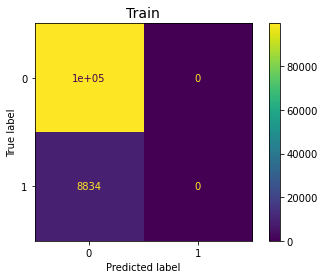

array([99651,     0,  8834,     0])

In [54]:
plot_confusion_matrix(y_true, y_pred, "Train")

In [55]:
### Confusion_matrix for train
confusion_matrix(y_true, y_pred)

array([[99651,     0],
       [ 8834,     0]])

In [56]:
y_true_test = df_prob_test['class_true'].values.tolist()
y_pred_test = df_prob_test['class_pred'].values.tolist()

In [57]:
# y_true_all = df_prob_all['class_true'].values.tolist()
# y_pred_all = df_prob_all['class_pred'].values.tolist()

In [58]:
# y_true.extend(y_true_test)
# y_pred.extend(y_pred_test)

In [59]:
### Confusion_matrix for all
# confusion_matrix(y_true, y_pred)

In [60]:
### Confusion_matrix for test
confusion_matrix(y_true_test, y_pred_test)

array([[42708,     0],
       [ 3786,     0]])

In [61]:
### Confusion_matrix for all
# confusion_matrix(y_true_all, y_pred_all)

In [62]:
# plot_confusion_matrix(y_true, y_pred, "ALL")

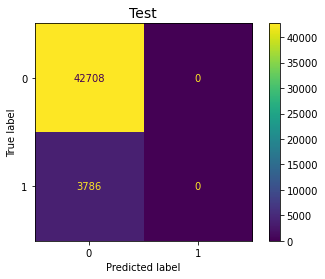

array([42708,     0,  3786,     0])

In [63]:
plot_confusion_matrix(y_true_test, y_pred_test, "Test")

In [64]:
# feature_importance_df(clf,Xcols)

/tmp/ipykernel_27376/2371775043.py:201: RuntimeWarning: invalid value encountered in long_scalars
  def_rate = np.round(100*num_def/num_cust,2)
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


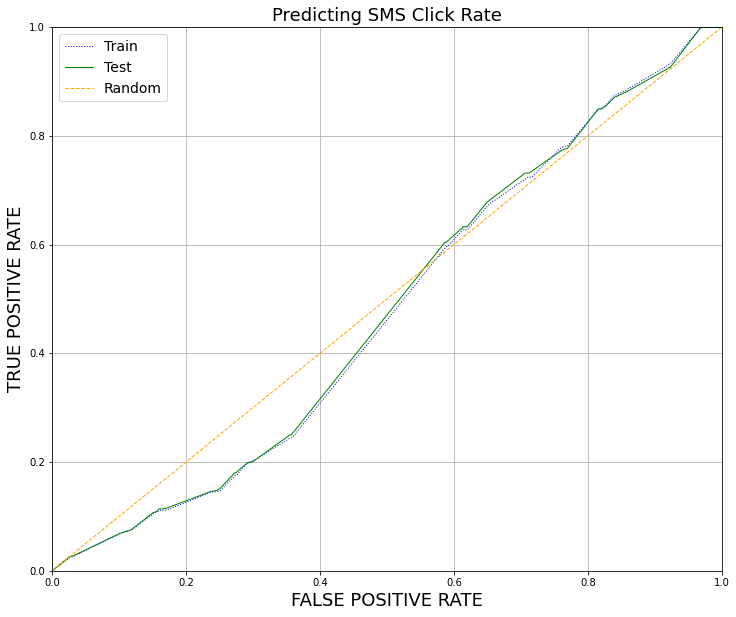

In [65]:
plot_roc(pred_train,pred_test,'Train','Test','b','g',':','-',1,1,'Predicting SMS Click Rate',fignum=1)
# print(dummy)
uid_bins,df_bins = deciles_split(df_prob_test,'pos_prob',bins_split=None,min_pt=-0.01,split_type='deciles')

avg_drate_threshold = 60
avg_crate_threshold = 7

In [66]:
df_bins#.to_csv("df_bins_data.csv")

,decile,left,right,Num Cust,% Cust,Num Def,% Def,Def Rate,Cum Num Cust,Cum % Cust,Cum Num Def,Cum % Def
band,,,,,,,,,,,,
10,100,0.090432,1.000000,4588,9.87,261,6.89,5.69,4588,9.87,261,6.89
9,90,0.079154,0.090432,3063,6.59,172,4.54,5.62,7651,16.46,433,11.43
8,80,0.071423,0.079154,5938,12.77,329,8.69,5.54,13589,29.23,762,20.12
7,70,0.070281,0.071423,2788,6.00,205,5.41,7.35,16377,35.23,967,25.53
6,60,0.070281,0.070281,0,0.00,0,0.00,NaN,16377,35.23,967,25.53
5,50,0.070044,0.070281,11059,23.79,1322,34.92,11.95,27436,59.02,2289,60.45
4,40,0.068222,0.070044,2937,6.32,283,7.47,9.64,30373,65.34,2572,67.92
3,30,0.065301,0.068222,5411,11.64,367,9.69,6.78,35784,76.98,2939,77.61
2,20,0.062671,0.065301,4109,8.84,393,10.38,9.56,39893,85.82,3332,87.99


In [67]:
# plot_roc(pred_train,pred_test,'Train','Test','b','g',':','-',1,1,'Predicting SMS Click Rate',fignum=1)
# # print(dummy)
# uid_bins,df_bins = deciles_split(df_prob_test,'pos_prob',bins_split=None,min_pt=-0.01,split_type='deciles')

# avg_drate_threshold = 60
# avg_crate_threshold = 7

In [68]:
# drate_list = []
# crate_list = []
# bin_names = []
# for key, value in uid_bins.items():
#     drate = df.loc[value]['delivery_rate']
#     crate = df.loc[value]['clicked_rate']
#     drate_avg = drate.mean()
#     crate_avg = crate.mean()
    
#     drate_list.append(drate_avg)
#     crate_list.append(crate_avg)
    
#     bin_names.append(key)

In [69]:
# band_avg_click_rate_df = pd.DataFrame({'band':bin_names, 'avg_click_rate':crate_list})

In [70]:
# band_avg_click_rate_df

In [71]:
# out = dict()
# out['model'] = clf
# out['orig_data'] = df
# out['df_bins'] = df_bins
# out['band_avg_click_rate'] = band_avg_click_rate_df
# out['pred_train'] = pred_train
# out['pred_test'] = pred_test
# out['encoding'] = dict()
# out['encoding']['circle'] = circle_enc_key
# out['encoding']['day_of_week'] = weekday_enc_key
# out['encoding']['avg_sms_len'] = avg_sms_len_enc_key

In [72]:
# func_save_joblib(out, '/home/aamin/files/marketing/copy', 'MSL_Marketing_Model_V1')

In [73]:
# fig, ax1 = plt.subplots(figsize=(12,8))
  
# color = 'blue'
# ax1.set_xlabel('Decile',fontsize=14)
# ax1.set_ylabel('Average Delivery Rate',fontsize=14, color=color)
# ax1.plot(bin_names, drate_list,'b^:',markersize=10, linewidth=1)
# ax1.plot(bin_names, avg_drate_threshold*np.ones((len(bin_names),1)),'b--', linewidth=2)

# plt.grid(True)

# ax2 = ax1.twinx()
  
# color = 'magenta'
# ax2.set_ylabel('Average Click Rate',fontsize=14, color=color)
# ax2.plot(bin_names, crate_list,'ms:',markersize=10, linewidth=1)
# ax2.plot(bin_names, avg_crate_threshold*np.ones((len(bin_names),1)),'m--', linewidth=2)
# plt.title('Optimizing Delivery and Click Rates', fontweight ="bold",fontsize=16)

# # plt.legend(['Delivery Rate','Click Rate'])

# plt.grid(True)
# plt.show()

In [74]:
def extract_class_df(df_prob_,hdr='conf'):
    tn=func_GetDFRows(df_prob_,hdr,'tn','eq')
    fn=func_GetDFRows(df_prob_,hdr,'fn','eq')
    fp=func_GetDFRows(df_prob_,hdr,'fp','eq')
    tp=func_GetDFRows(df_prob_,hdr,'tp','eq')
    return (tn,fn,fp,tp)

def make_subplot_pod(tp,fp,hdr,leg_a,leg_b,str1,bins1,stat,shrink)->None:
    leg1 = []
    if len(tp) > 0:
        sns_histplot(tp,hdr,bins1,stat,'b','--',shrink)
        leg1.append(str1+' '+leg_a)
    if len(fp) > 0:
        sns_histplot(fp,hdr,bins1,stat,'r',':',shrink)
        leg1.append(str1+' '+leg_b)
    plt.legend(leg1,fontsize=14)
    plt.xlabel('POD',fontsize=14)
    plt.ylabel('')
    plt.tick_params(axis='both', which='major', labelsize=18)
    return

#%%
def plot_POD(pred_train,pred_test,str1,str2,bins1,bins2,fignum,figsize,stat='count',\
             hdr='pos_prob',shrink=1):
    
    tn_train,fn_train,fp_train,tp_train = extract_class_df(pred_train)
    
    if pred_test is not None:
        tn_test,fn_test,fp_test,tp_test = extract_class_df(pred_test)
        
    plt.figure(num=fignum,figsize=figsize)
    plt.subplot(2,2,2)
    make_subplot_pod(tp_train,fp_train,hdr,'TP','FP',str1,bins1,stat,shrink)
    
    plt.subplot(2,2,1)
    make_subplot_pod(tn_train,fn_train,hdr,'TN','FN',str1,bins1,stat,shrink)
    
    if pred_test is not None:
        plt.subplot(2,2,4)
        make_subplot_pod(tp_test,fp_test,hdr,'TP','FP',str2,bins2,stat,shrink)
        
        plt.subplot(2,2,3)
        make_subplot_pod(tn_test,fn_test,hdr,'TN','FN',str2,bins2,stat,shrink)
        
    return

def sns_histplot(POD_test0_tn,hdr,bins,stat,color,linestyle,shrink):
    import seaborn as sns
    sns.histplot(data=POD_test0_tn, x=hdr, y=None, hue=None,\
                 weights=None, stat=stat, bins=bins, binwidth=None, binrange=None,\
                 discrete=None, cumulative=False, common_bins=True, common_norm=True,\
                 multiple='layer', element='bars', fill=False, shrink=shrink, kde=True, kde_kws=None,\
                 line_kws=None, thresh=0, pthresh=None, pmax=None, cbar=False, cbar_ax=None,\
                 cbar_kws=None, palette=None, hue_order=None, hue_norm=None, color=color, log_scale=None,\
                 legend=True, linestyle=linestyle)
    return

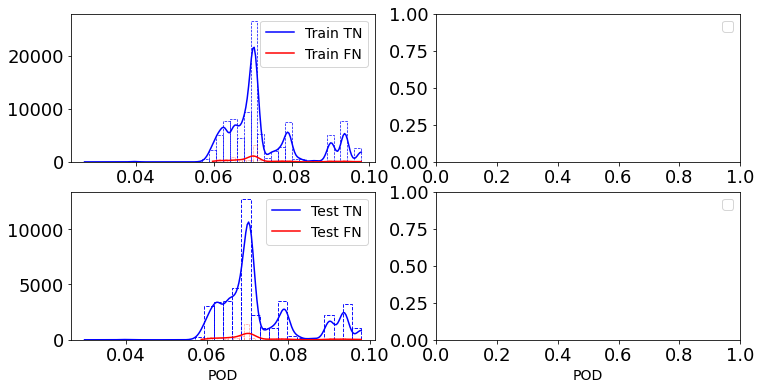

In [75]:
plot_POD(df_prob_train,df_prob_test,'Train','Test',40,30,1,(12,6),stat='count',\
             hdr='pos_prob',shrink=1)

In [76]:
indepen_vars = ['Circle']
# control_vars = ['SMS Language',
#                 'Day of Week', 
#                 'Median Day of Month ceil',
#                 'Avg SMS Length_cat',
#                 'Hour of Day']

# control_vars = ['SMS Language',
#             'Day of Week',
#              'Median Day of Month ceil',
#              'Avg SMS Length_cat',
#              'Hour of Day',
#              'Median Num SMS Sent']

control_vars = ['Delivered_Date_year',
                'Delivered_Date_month',
                'Delivered_Date_day',
                'Day of Week',
                'SMS Language',
                'Num words in SMS'
                ]

control_var_levels = {}
for i in range(len(control_vars)):
    var_i = control_vars[i]
    df_v_i = pd.DataFrame(np.unique(df[var_i].values).tolist())
    df_v_i.columns=[var_i]
    control_var_levels[i] = df_v_i

KeyError: 'Delivered_Date_year'

In [ ]:
control_var_levels

{0:   Delivered_Date_year
 0                2021
 1                2022,
 1:   Delivered_Date_month
 0                   05
 1                   09
 2                   11
 3                   12,
 2:    Delivered_Date_day
 0                  02
 1                  05
 2                  06
 3                  07
 4                  09
 5                  11
 6                  12
 7                  13
 8                  14
 9                  16
 10                 18
 11                 24
 12                 25,
 3:   Day of Week
 0      Friday
 1      Monday
 2    Saturday
 3      Sunday
 4    Thursday
 5     Tuesday
 6   Wednesday,
 4:       Circle
 0      Delhi
 1  Hyderabad
 2  Karnataka,
 5:   SMS Language
 0           en
 1           hi
 2           kn,
 6:    Num words in SMS
 0                31
 1                32
 2                34
 3                41
 4                44}

In [ ]:
def customize_campaign(data, features, circle, df_bins, hour_of_day_start=None, hour_of_day_end=None, accepted_languages=None):
    
    index_name = 'SN'
    
    indepen_vars = ['Circle']
    control_vars = ['Delivered_Date_year',
                    'Delivered_Date_month',
                    'Delivered_Date_day',
                    'Day of Week',
                    'SMS Language',
                    'Num words in SMS'
                    ]

    control_var_levels = {}
    for i in range(len(control_vars)):
        control_var = control_vars[i]
        df_unique_vals = pd.DataFrame(np.unique(data[control_var].values).tolist())
        df_unique_vals.columns=[control_var]
        control_var_levels[i] = df_unique_vals
        
    df_all_permutations = all_attribute_permutations(control_var_levels)
    
    df_indep = data[['Circle']]
    
    df_filter_by_circle = df_lib.func_GetDFRows(df_indep,'Circle',circle,'eq')
    df_filter_by_circle.drop_duplicates(keep='first',inplace=True)
    
    df_concat = [df_filter_by_circle, df_all_permutations]
    df_concat_permutations = all_attribute_permutations(df_concat)
    df_concat_permutations.index = np.arange(1,len(df_concat_permutations)+1)
    df_filter_by_circle.drop_duplicates(keep='first',inplace=True)
    df_concat_permutations_orig = df_concat_permutations.copy()
    
    df_concat_permutations = feature_decoding(df_concat_permutations,'Delivered_Date_year',delivered_date_year_enc_key,None)
    df_concat_permutations = feature_decoding(df_concat_permutations,'Delivered_Date_month',delivered_date_month_enc_key,None)
    df_concat_permutations = feature_decoding(df_concat_permutations,'Delivered_Date_day',delivered_date_day_enc_key,None)
    df_concat_permutations = feature_decoding(df_concat_permutations,'Day of Week',day_of_week_enc_key,None)
    df_concat_permutations = feature_decoding(df_concat_permutations,'Circle',circle_enc_key,None)
    df_concat_permutations = feature_decoding(df_concat_permutations,'SMS Language',sms_language_enc_key,None)
    
    prediction_new = prediction(clf,
                      df_concat_permutations,
                      None,
                      index_name,
                      df_concat_permutations.index,
                      features,
                      prob_threshold=0.45)

    df_prob_new = pd.concat([prediction_new['df_prob'],df_concat_permutations_orig],axis=1)

    df_prob_new_dec = map_deciles(df_prob_new,df_bins,sort_band='descending')
    
    #df_filter_with_class1 = df_lib.func_GetDFRows(df_prob_new_dec,'class_pred',1,'eq')
    
#     if accepted_languages!= None:
#         df_filter_with_language = df_filter_with_class1[df_filter_with_class1['SMS Language'].isin(accepted_languages)]
#         #df_filter_by_bands = df_lib.func_GetDFRows(df_filter_with_language,'band', 9, 'geq')
        
#     else:
#         #df_filter_by_bands = df_lib.func_GetDFRows(df_filter_with_class1,'band', 9, 'geq')
#         df_filter_with_language = df_filter_with_class1.copy()
        
    return df_prob_new_dec #df_filter_with_class1 #df_filter_with_language

#     df1=df_lib.func_GetDFRows(df1,'Hour of Day',9,'geq',18,'leq')
#     df1=df_lib.func_GetDFRows(df1,'Avg Day of Month_cat','week_1','eq')
#     df1=df_lib.func_GetDFRows(df1,'Day of Week','Monday','eq')

In [ ]:
ktaka_df = customize_campaign(df, Xcols, 'Karnataka', df_bins)

/tmp/ipykernel_33813/2375217756.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter_by_circle.drop_duplicates(keep='first',inplace=True)
/tmp/ipykernel_33813/2375217756.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter_by_circle.drop_duplicates(keep='first',inplace=True)
/home/aamin/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
ktaka_df

,neg_prob,pos_prob,class_pred,Circle,Delivered_Date_year,Delivered_Date_month,Delivered_Date_day,Day of Week,SMS Language,Num words in SMS,band
3940,0.428000,0.572000,1.0,Karnataka,2021,11,24,Sunday,hi,44,7
3925,0.428000,0.572000,1.0,Karnataka,2021,11,24,Saturday,hi,44,7
3955,0.428000,0.572000,1.0,Karnataka,2021,11,24,Thursday,hi,44,7
3505,0.428145,0.571855,1.0,Karnataka,2021,11,13,Saturday,hi,44,7
3520,0.428145,0.571855,1.0,Karnataka,2021,11,13,Sunday,hi,44,7
...,...,...,...,...,...,...,...,...,...,...,...
10653,0.996541,0.003459,0.0,Karnataka,2022,12,18,Sunday,en,34,1
10548,0.996541,0.003459,0.0,Karnataka,2022,12,16,Sunday,en,34,1
10038,0.996541,0.003459,0.0,Karnataka,2022,12,09,Thursday,en,34,1
10638,0.996541,0.003459,0.0,Karnataka,2022,12,18,Saturday,en,34,1


In [ ]:
# ktaka_df_copy = ktaka_df[ktaka_df["SMS Language"].isin(["hi","en","kn"])]

In [ ]:
# weeks : week 1 - 1-7; week 2 - 8-14; week 3 - 15-21; week 4 - 22-28; week 5 - 29-31
# circle_df = ktaka_df_copy.copy()
# circle_df.drop(['Median Num SMS Sent','neg_prob','class_pred'], axis=1, inplace=True)

# circle_df.loc[((circle_df['Hour of Day']>=9) & (circle_df['Hour of Day']<=12)),'Session of Day']='9AM-12PM'
# circle_df.loc[((circle_df['Hour of Day']>12) & (circle_df['Hour of Day']<=15)),'Session of Day']='12:01PM-3PM'
# circle_df.loc[((circle_df['Hour of Day']>15) & (circle_df['Hour of Day']<=18)),'Session of Day']='3:01PM-6PM'
# circle_df.loc[((circle_df['Hour of Day']>18) & (circle_df['Hour of Day']<=21)),'Session of Day']='6:01PM-9PM'
# circle_df.loc[((circle_df['Hour of Day']>21) & (circle_df['Hour of Day']<=0)),'Session of Day']='9:01PM-12PM'
# circle_df.loc[((circle_df['Hour of Day']>0) & (circle_df['Hour of Day']<9)),'Session of Day']='12:01AM-8:59AM'

# condition_band = (circle_df['band'].isin([10,9,8]))
# condition_week = ((circle_df['Median Day of Month ceil']>14) & (circle_df['Median Day of Month ceil']<=21)) 
#condition_date = ((circle_df['Median Day of Month ceil']>14) & (circle_df['Median Day of Month ceil']<=21)) 
#condition_hour = ((circle_df['Hour of Day']>=9) & (circle_df['Hour of Day']<=12) )

In [ ]:
# circle_df[condition_band & condition_week].drop(['Median Day of Month ceil'], axis=1).drop_duplicates(['Day of Week','Session of Day'], keep='first').head(5) #.head(20)

In [ ]:
# circle_df[circle_df["band"].isin([10,9,8])]

In [ ]:
# day_sorter = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
# week_sorter = ['week_1 : 1-7','week_2 : 8-14','week_3 : 15-21','week_4 : 22-28','week_5 : 29-31']
# session_sorter = ['9AM-12PM', '12:01PM-3PM', '3:01PM-6PM','6:01PM-9PM','9:01PM-12PM','12:01AM-8:59AM']

# circle_df['Day of Week'] = circle_df['Day of Week'].astype("category")
# circle_df['Day of Week'] = circle_df['Day of Week'].cat.set_categories(day_sorter)
# #circle_df.sort_values(["Day of Week"])

# circle_df['week'] = circle_df['week'].astype("category")
# circle_df['week'] = circle_df['week'].cat.set_categories(week_sorter)
# #circle_df.sort_values(["week"])

# circle_df['Session of Day'] = circle_df['Session of Day'].astype("category")
# circle_df['Session of Day'] = circle_df['Session of Day'].cat.set_categories(session_sorter)
# circle_df.sort_values(['week','Day of Week',"Session of Day"])


In [ ]:
def get_appropriate_df_for_campaign(permutation_circle_df, band_list = [10,9,8], lang_list = ["hi","en","kn"], 
                                    week_start_date=None, week_end_date=None, week_num=None):
    
    # weeks : week 1 - 1-7; week 2 - 8-14; week 3 - 15-21; week 4 - 22-28; week 5 - 29-31
    circle_df = permutation_circle_df.copy()
    circle_df.drop(['Median Num SMS Sent','neg_prob','class_pred'], axis=1, inplace=True)

    circle_df.loc[((circle_df['Hour of Day']>=9) & (circle_df['Hour of Day']<=12)),'Session of Day']='9AM-12PM'
    circle_df.loc[((circle_df['Hour of Day']>12) & (circle_df['Hour of Day']<=15)),'Session of Day']='12:01PM-3PM'
    circle_df.loc[((circle_df['Hour of Day']>15) & (circle_df['Hour of Day']<=18)),'Session of Day']='3:01PM-6PM'
    circle_df.loc[((circle_df['Hour of Day']>18) & (circle_df['Hour of Day']<=21)),'Session of Day']='6:01PM-9PM'
    circle_df.loc[((circle_df['Hour of Day']>21) & (circle_df['Hour of Day']<24)),'Session of Day']='9:01PM-12PM'
    circle_df.loc[((circle_df['Hour of Day']>=0) & (circle_df['Hour of Day']<9)),'Session of Day']='12:01AM-8:59AM'

    # condition_band = (circle_df['band'].isin(band_list))
    condition_week = ((circle_df['Median Day of Month ceil']>=week_start_date) & (circle_df['Median Day of Month ceil']<=week_end_date)) 
    condition_language = (circle_df['SMS Language'].isin(lang_list))
    
    final_df = circle_df[ condition_week & condition_language ].drop(['Median Day of Month ceil'], axis=1).drop_duplicates(['Day of Week','Session of Day'], keep='first') #.head(20)
    final_df['week'] = f'week_{week_num} : {week_start_date}-{week_end_date}'
    
    return final_df

In [ ]:
def get_final_campaign_df(permutation_circle_df, band_list = [10,9,8]):
    
    week1 = get_appropriate_df_for_campaign(permutation_circle_df, band_list = band_list, 
                                    week_start_date=1, week_end_date=7, week_num=1)
    
    week2 = get_appropriate_df_for_campaign(permutation_circle_df, band_list = band_list, 
                                    week_start_date=8, week_end_date=14, week_num=2)
    
    week3 = get_appropriate_df_for_campaign(permutation_circle_df, band_list = band_list, 
                                    week_start_date=15, week_end_date=21, week_num=3)
    
    week4 = get_appropriate_df_for_campaign(permutation_circle_df, band_list = band_list, 
                                    week_start_date=22, week_end_date=28, week_num=4)
    
    week5 = get_appropriate_df_for_campaign(permutation_circle_df, band_list = band_list, 
                                    week_start_date=29, week_end_date=31, week_num=5)
    
    all_weeks = pd.concat([week1, week2, week3, week4, week5])
    
    return all_weeks

In [ ]:
data_karnataka_2 = get_final_campaign_df(ktaka_df, band_list = [10,9,8])

In [ ]:
data_karnataka_2["SMS Language"].value_counts()

en    190
hi     16
kn      4
Name: SMS Language, dtype: int64

In [ ]:
data_karnataka = get_appropriate_df_for_campaign(ktaka_df, band_list = [10,9,8], 
                                    week_start_date=8, week_end_date=14, week_num=2)

In [ ]:
data_karnataka = data_karnataka[['pos_prob','band','Circle','week','Day of Week','SMS Language','Avg SMS Length_cat','Session of Day','Hour of Day']]

In [ ]:
day_sorter = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
week_sorter = ['week_1 : 1-7','week_2 : 8-14','week_3 : 15-21','week_4 : 22-28','week_5 : 29-31']
session_sorter = ['9AM-12PM', '12:01PM-3PM', '3:01PM-6PM','6:01PM-9PM','9:01PM-12PM','12:01AM-8:59AM']

data_karnataka['Day of Week'] = data_karnataka['Day of Week'].astype("category")
data_karnataka['Day of Week'] = data_karnataka['Day of Week'].cat.set_categories(day_sorter)
#data_karnataka.sort_values(["Day of Week"])

data_karnataka['week'] = data_karnataka['week'].astype("category")
data_karnataka['week'] = data_karnataka['week'].cat.set_categories(week_sorter)
#data_karnataka.sort_values(["week"])

data_karnataka['Session of Day'] = data_karnataka['Session of Day'].astype("category")
data_karnataka['Session of Day'] = data_karnataka['Session of Day'].cat.set_categories(session_sorter)
data_karnataka.sort_values(['week','Day of Week',"Session of Day"],inplace = True)

In [ ]:
from datetime import datetime

def change_24hr_to_12hr_format_time(hour):
    d = datetime.strptime(str(hour), "%H")
    return d.strftime("%I:%M %p")

In [ ]:
data_karnataka['SMS Language'].replace('en', 'English',inplace = True)
data_karnataka['SMS Language'].replace('hi', 'Hindi',inplace = True)
data_karnataka['SMS Language'].replace('kn', 'Kannada',inplace = True)

In [ ]:
data_karnataka["Hour of Day"]  = data_karnataka["Hour of Day"].apply(lambda x: change_24hr_to_12hr_format_time(x))

In [ ]:
data_karnataka

,pos_prob,band,Circle,week,Day of Week,SMS Language,Avg SMS Length_cat,Session of Day,Hour of Day
6571,0.898847,10,Karnataka,week_2 : 8-14,Monday,English,1-180,9AM-12PM,09:00 AM
7143,0.902367,10,Karnataka,week_2 : 8-14,Monday,English,201-300,12:01PM-3PM,03:00 PM
7029,0.924536,10,Karnataka,week_2 : 8-14,Monday,English,300+,3:01PM-6PM,06:00 PM
7031,0.917246,10,Karnataka,week_2 : 8-14,Monday,English,300+,6:01PM-9PM,07:00 PM
6157,0.340546,5,Karnataka,week_2 : 8-14,Monday,English,181-200,9:01PM-12PM,10:00 PM
6409,0.900735,10,Karnataka,week_2 : 8-14,Monday,English,1-180,12:01AM-8:59AM,08:00 AM
26771,0.925680,10,Karnataka,week_2 : 8-14,Tuesday,English,181-200,9AM-12PM,09:00 AM
61422,0.659536,8,Karnataka,week_2 : 8-14,Tuesday,Hindi,300+,12:01PM-3PM,02:00 PM
26705,0.430644,6,Karnataka,week_2 : 8-14,Tuesday,English,300+,3:01PM-6PM,04:00 PM
26632,0.384640,5,Karnataka,week_2 : 8-14,Tuesday,English,181-200,6:01PM-9PM,07:00 PM


In [ ]:
data_karnataka.to_csv("/home/aamin/files/marketing/copy/recommendation/Janurary/Jan_week_2.csv",index = False)

In [ ]:
def get_appropriate_bands(df_circle, band_avg_click_rate_df,
                          day_of_week=None, 
                          date_of_month=None, 
                          hour_of_day=[]):
    
    df_circle = df_circle.merge(band_avg_click_rate_df, on='band')
    
    final_df = df_circle[(df_circle['Day of Week']==day_of_week) &
                         (df_circle['Median Day of Month ceil']==date_of_month) &
                         (df_circle['Hour of Day'].isin(hour_of_day))]
    
    return final_df

In [ ]:
get_appropriate_bands(ktaka_df,band_avg_click_rate_df, day_of_week='Friday', date_of_month=2, hour_of_day=[9,10,11,12])

,neg_prob,pos_prob,class_pred,Circle,SMS Language,Day of Week,Median Day of Month ceil,Avg SMS Length_cat,Hour of Day,Median Num SMS Sent,band,avg_click_rate
7865,0.185290,0.814710,1.0,Karnataka,en,Friday,2.0,181-200,9,2.0,9,15.997029
8355,0.189254,0.810746,1.0,Karnataka,en,Friday,2.0,181-200,9,3.0,9,15.997029
9451,0.200904,0.799096,1.0,Karnataka,en,Friday,2.0,1-180,9,2.0,9,15.997029
9718,0.202872,0.797128,1.0,Karnataka,en,Friday,2.0,201-300,9,2.0,9,15.997029
9926,0.204868,0.795132,1.0,Karnataka,en,Friday,2.0,1-180,9,3.0,9,15.997029
...,...,...,...,...,...,...,...,...,...,...,...,...
108330,0.742487,0.257513,0.0,Karnataka,te,Friday,2.0,300+,12,2.0,4,7.137562
108331,0.742487,0.257513,0.0,Karnataka,te,Friday,2.0,300+,12,3.0,4,7.137562
108332,0.742487,0.257513,0.0,Karnataka,te,Friday,2.0,201-300,12,2.0,4,7.137562
108333,0.742487,0.257513,0.0,Karnataka,kn,Friday,2.0,300+,12,3.0,4,7.137562


In [ ]:
# ktaka_df_copy.merge(band_avg_click_rate_df, on='band')

In [ ]:
l = []
for i in range(4,1,-1):
    l.append("False "*i)

In [ ]:
l

['False False False False ', 'False False False ', 'False False ']

In [ ]:
ktaka_df_10 = ktaka_df[ktaka_df['band']==10]

In [ ]:
ktaka_df_10['SMS Language'].value_counts()

en    2828
mr    1492
hi     168
Name: SMS Language, dtype: int64

In [ ]:
ktaka_df['quartile'] = pd.qcut(ktaka_df['pos_prob'], q=4)

In [ ]:
ktaka_df['quartile'].value_counts()

(0.212, 0.301]     43524
(0.0093, 0.212]    43407
(0.478, 0.964]     43398
(0.301, 0.478]     43271
Name: quartile, dtype: int64

In [ ]:
ktaka_df_top_q = func_GetDFRows(ktaka_df,'pos_prob',0.76,'gt',1,'leq')

In [ ]:
ktaka_df_top_q

,neg_prob,pos_prob,class_pred,Circle,SMS Language,Day of Week,Median Day of Month ceil,Avg SMS Length_cat,Hour of Day,Median Num SMS Sent,band,quartile
8429,0.036004,0.963996,1.0,Karnataka,en,Monday,22.0,201-300,18,2.0,10,"(0.478, 0.964]"
8469,0.036004,0.963996,1.0,Karnataka,en,Monday,22.0,300+,18,2.0,10,"(0.478, 0.964]"
8269,0.036004,0.963996,1.0,Karnataka,en,Monday,21.0,201-300,18,2.0,10,"(0.478, 0.964]"
8309,0.036004,0.963996,1.0,Karnataka,en,Monday,21.0,300+,18,2.0,10,"(0.478, 0.964]"
8467,0.038650,0.961350,1.0,Karnataka,en,Monday,22.0,300+,17,2.0,10,"(0.478, 0.964]"
...,...,...,...,...,...,...,...,...,...,...,...,...
7476,0.239970,0.760030,1.0,Karnataka,en,Monday,16.0,201-300,21,3.0,9,"(0.478, 0.964]"
7516,0.239970,0.760030,1.0,Karnataka,en,Monday,16.0,300+,21,3.0,9,"(0.478, 0.964]"
5988,0.239974,0.760026,1.0,Karnataka,en,Monday,7.0,181-200,17,3.0,9,"(0.478, 0.964]"
26494,0.239989,0.760011,1.0,Karnataka,en,Tuesday,11.0,201-300,10,3.0,9,"(0.478, 0.964]"


In [ ]:
ktaka_df_top_q['Avg SMS Length_cat'].value_counts()

181-200    3544
1-180      3540
201-300    3538
300+       3251
Name: Avg SMS Length_cat, dtype: int64

ktaka_df_10[ktaka_df_10['quartile'] == pd.Interval(left=0.881, right=0.911)]

ktaka_df_10['quartile'].value_counts()

In [ ]:
ktaka_df_top_q[ktaka_df_top_q['quartile'] == pd.Interval(left=0.76, right=0.923)]['Day of Week'].value_counts()

Series([], Name: Day of Week, dtype: int64)

In [ ]:
ktaka_df_top_q[ktaka_df_top_q['quartile'] == pd.Interval(left=0.76, right=0.923)]['Avg Day of Month_cat'].value_counts()

KeyError: 'Avg Day of Month_cat'

In [ ]:
ktaka_df_top_q[ktaka_df_top_q['quartile'] == pd.Interval(left=0.76, right=0.923)]['SMS Language'].value_counts()

Hindi      300
English    290
Kannada    231
Name: SMS Language, dtype: int64

In [ ]:
ktaka_df_top_q[ktaka_df_top_q['quartile'] == pd.Interval(left=0.76, right=0.923)]['Session of Day'].value_counts()

3.0    301
4.0    250
2.0    231
6.0     23
5.0     16
Name: Session of Day, dtype: int64

In [ ]:
ktaka_df_10[(ktaka_df_10['quartile'] == pd.Interval(left=0.881, right=0.911)) &
            (ktaka_df_10['Avg Day of Month_cat']=='week_2') &
            (ktaka_df_10['Day of Week']=='Monday')]['SMS Language'].value_counts()

Hindi      14
English    14
Name: SMS Language, dtype: int64

In [ ]:
sorted_df = ktaka_df.sort_values(by=['quartile'], ascending=False).sort_values(by=['Session of Day'], ascending=True)

In [ ]:
sorted_df

,neg_prob,pos_prob,class_pred,Circle,SMS Language,Day of Week,Session of Day,Avg SMS Length_cat,Avg Day of Month_cat,band,quartile
93,0.154545,0.845455,1.0,Karnataka,English,Monday,1.0,short,week_1,10,"(0.842, 0.91]"
96,0.106615,0.893385,1.0,Karnataka,English,Monday,1.0,short,week_4,10,"(0.842, 0.91]"
90,0.106615,0.893385,1.0,Karnataka,English,Monday,1.0,medium,week_2,10,"(0.842, 0.91]"
94,0.106615,0.893385,1.0,Karnataka,English,Monday,1.0,short,week_2,10,"(0.842, 0.91]"
1606,0.272999,0.727001,1.0,Karnataka,Kannada,Tuesday,1.0,short,week_2,9,"(0.724, 0.761]"
...,...,...,...,...,...,...,...,...,...,...,...
504,0.246205,0.753795,1.0,Karnataka,English,Tuesday,7.0,short,week_4,9,"(0.724, 0.761]"
413,0.195346,0.804654,1.0,Karnataka,English,Thursday,7.0,medium,week_1,10,"(0.801, 0.842]"
420,0.175474,0.824526,1.0,Karnataka,English,Thursday,7.0,short,week_4,10,"(0.801, 0.842]"
1425,0.196139,0.803861,1.0,Karnataka,Kannada,Saturday,7.0,short,week_1,10,"(0.801, 0.842]"


In [ ]:
dff = fr_lib.func_ReadCSVFile(pathName=pname, fileName=fname)[0]
dff.set_index('SN',inplace=True)

In [ ]:
dff

,Circle,SMS Language,Day of Week,Hour of Day,sms_sent,sms_delivered,delivery_rate,sms_clicked,clicked_rate,Avg Num SMS Sent,...,Avg Timelag (s) wo 0,Median Timelag (s) wo 0,Avg Day of Month,Median Day of Month,Avg Day of Month wo 0,Median Day of Month wo 0,Avg Num Words,Median Num Words,Avg Num Words wo 0,Median Num Words wo 0
SN,,,,,,,,,,,,,,,,,,,,,
0,Andhra Pradesh,English,Friday,9,461,438.0,95.010846,77.0,17.579909,2.0,...,2497.259740,3.0,24.000000,24.0,24.000000,24.0,29.000000,29.0,29.000000,29.0
1,Andhra Pradesh,English,Friday,10,13919,7784.0,55.923558,780.0,10.020555,2.0,...,19488.629160,2.0,2.014225,2.0,2.014225,2.0,33.996767,34.0,33.996767,34.0
2,Andhra Pradesh,English,Friday,11,2238,366.0,16.353887,34.0,9.289617,2.0,...,2.968750,2.5,7.080429,2.0,7.080429,2.0,33.995532,34.0,33.995532,34.0
3,Andhra Pradesh,English,Friday,12,832,633.0,76.081731,106.0,16.745656,2.0,...,8016.303922,27.0,11.331731,12.0,11.331731,12.0,36.617788,37.0,36.617788,37.0
4,Andhra Pradesh,English,Friday,13,12,10.0,83.333333,0.0,0.000000,2.0,...,0.000000,0.0,11.000000,12.0,11.000000,12.0,36.000000,37.0,36.000000,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1763,West Bengal-Andaman Nicobar,English,Wednesday,15,9,0.0,0.000000,0.0,0.000000,2.0,...,0.000000,0.0,8.000000,8.0,8.000000,8.0,22.000000,22.0,22.000000,22.0
1764,West Bengal-Andaman Nicobar,English,Wednesday,16,7,5.0,71.428571,0.0,0.000000,2.0,...,0.000000,0.0,11.000000,11.0,11.000000,11.0,32.000000,32.0,32.000000,32.0
1765,West Bengal-Andaman Nicobar,English,Wednesday,19,70,64.0,91.428571,10.0,15.625000,2.0,...,39.000000,4.0,22.114286,22.0,22.114286,22.0,30.185714,29.0,30.185714,29.0


In [ ]:
ap = dff[dff['Circle']=='Andhra Pradesh']

<BarContainer object of 89 artists>

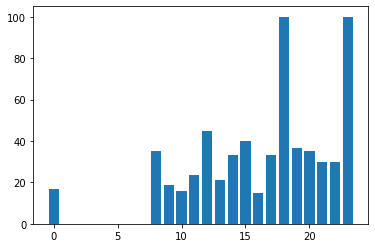

In [ ]:
ap['Hour of Day'], ap['clicked_rate']

In [ ]:
dff.groupby(['Circle','Hour of Day'])[['clicked_rate']].agg(np.mean)

clicked_rate
Circle                      Hour of Day              
Andhra Pradesh              0                5.555556
                            1                0.000000
                            2                0.000000
                            8               17.851331
                            9               13.531964
...                                               ...
West Bengal-Andaman Nicobar 19              21.875000
                            20               8.000000
                            21               0.000000
                            22               0.000000
                            23              25.000000

[444 rows x 1 columns]

In [ ]:
dff['Circle'].value_counts()

Andhra Pradesh                      89
Maharashtra-Goa                     88
Delhi                               87
Karnataka                           87
Mumbai                              84
Uttar Pradesh (East)                83
Madhya Pradesh-Chattisgarh          83
Gujarat                             82
Bihar-Jharkhand                     80
Tamil Nadu                          79
Rajasthan                           79
Haryana                             76
Uttar Pradesh (West)-Uttarakhand    74
Orissa                              74
Punjab                              73
Assam                               69
Chennai                             69
Kolkata                             68
West Bengal-Andaman Nicobar         65
Kerala                              60
Tamil Nadu-Chennai                  56
Jammu-Kashmir                       56
North East                          55
Himachal Pradesh                    52
Name: Circle, dtype: int64